# Sentiment Analysis of Reddit Comments on IPL Channels

In [1]:
import openai
from typing import List, Dict, Generator, Optional

import tiktoken
import pandas as pd
from dotenv import load_dotenv
import sys

import re
import random
import time
import praw
import os

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
model = "gpt-4o-mini"
load_dotenv(".env")

openai.api_key = os.environ["APIKEY"]

reddit = praw.Reddit(
    client_id=os.environ["REDDIT_CLIENT_ID"],
    client_secret=os.environ["REDDIT_CLIENT_SECRET"],
    user_agent="script:ipl.sentiment:v0.1 (by u/Scary_Bodybuilder542)",
)

In [3]:
def num_tokens_from_messages(messages, model="gpt-4o-mini"):    
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        encoding = tiktoken.get_encoding("cl100k_base")  # fallback

    if model in ["gpt-4o", "gpt-4o-mini", "gpt-3.5-turbo", "gpt-4", "gpt-4-0613"]:
        tokens_per_message = 3
        tokens_per_name = 1
    else:
        raise NotImplementedError(f"Token counting not implemented for model {model}.")

    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name

    num_tokens += 3 
    return num_tokens

## Getting Reddit Comments

In [4]:
DF_COLUMNS=["subreddit", "submission_id", "score", "comment_body"]
filename, subreddits = (
    "ipl_teams.csv",
    [
        "csk",                 
        "MumbaiIndians",
        "KolkataKnightRiders",
        "RCB",
        "DelhiCapitals",
        "SunRisersHyderabad",
        "RajasthanRoyals",
        "LucknowSuperGiant",
        "Gujarat_Titans",
        "PunjabKings",
    ]
)

In [5]:
def comment_generator(submission) -> Generator:
    for comment in submission.comments.list():
        if (
            hasattr(comment, "body")
            and comment.body != "[deleted]"
            and comment.body != "[removed]"
        ):
            yield (comment)

In [6]:
def collect_comments(
    filename: str,
    target_comments_per_subreddit: int,
    max_comments_per_submission: int,
    max_comment_length: int,
    reddit: praw.Reddit,
) -> pd.DataFrame:
    """
    Collect comments from the top submissions in each subreddit.
    Cache results at cache_filename.
    Return a dataframe with columns: subreddit, submission_id, score, comment_body
    """
    try:
        df = pd.read_csv(filename, index_col="id")
        assert df.columns.tolist() == DF_COLUMNS
    except FileNotFoundError:
        df = pd.DataFrame(columns=DF_COLUMNS)

    records = df.to_dict(orient="index")

    for subreddit_index, subreddit_name in enumerate(subreddits):
        print(f"Processing Subreddit: {subreddit_name}\n")
        processed_comments_for_subreddit = len(df[df["subreddit"] == subreddit_name])
        if processed_comments_for_subreddit >= target_comments_per_subreddit:
            print(f"Enough comments fetched for {subreddit_name}, continuing to next subreddit.")
            continue

        for submission in reddit.subreddit(subreddit_name).top(time_filter="month"):
            if processed_comments_for_subreddit >= target_comments_per_subreddit:
                break

            processed_comments_for_submission = len(df[df["submission_id"] == submission.id])
            for comment in comment_generator(submission):
                if (
                    processed_comments_for_submission >= max_comments_per_submission
                    or processed_comments_for_subreddit >= target_comments_per_subreddit
                ):
                    break

                if comment.id in records:
                    print(f"Skipping comment {subreddit_name}-{submission.id}-{comment.id} because we already have it")
                    continue

                body = comment.body[:max_comment_length].strip()
                records[comment.id] = {
                    "subreddit": subreddit_name,
                    "submission_id": submission.id,
                    "comment_body": body,
                }

                processed_comments_for_subreddit += 1
                processed_comments_for_submission += 1

            print(f"CSV rewritten with {len(records)} rows.")
            df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
            df.to_csv(filename, index_label="id")

    print("Completed.")
    return df

## Sentiment Analysis on Comments

In [7]:
MAX_ATTEMPTS = 3


def generate_prompt_messages(s: str) -> List[Dict]:
    return [
        {
            "role": "user",
            "content": """
Score the reddit comment from -1 to 1, where -1 is most negative and 1 is most positive:
The traffic is quite annoying.
""".strip(),
        },
        {"role": "assistant", "content": "-0.75"},
        {
            "role": "user",
            "content": """
Score this from -1 to 1: 
The library is downtown.
""".strip(),
        },
        {"role": "assistant", "content": "0.0"},
        {
            "role": "user",
            "content": """
Score this:
Even though it's humid, I really love the summertime.
""".strip(),
        },
        {"role": "assistant", "content": "0.7"},
        {
            "role": "user",
            "content": f"""
Score this:
{s}
""".strip(),
        },
    ]

In [8]:
class UnscorableCommentError(Exception):
    pass

from tenacity import (
    retry,
    wait_random_exponential,
    retry_if_exception_type,
    stop_after_attempt,
)

@retry(
    wait=wait_random_exponential(multiplier=1, max=30),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(UnscorableCommentError)
    | retry_if_exception_type(openai.APIConnectionError)
    | retry_if_exception_type(openai.APIError)
    | retry_if_exception_type(openai.RateLimitError),
    reraise=True,  # Reraise the last exception
)
def score_sentiment(s: str, model: str) -> float:
    messages = generate_prompt_messages(s)
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
    )
    score_response = response.choices[0].message.content.strip()
    # This will raise an Attribute Error if the regular expression doesn't match
    try:
        return float(re.search(r"([-+]?\d*\.?\d+)", score_response).group(1))
    except AttributeError:
        raise UnscorableCommentError(f"Could not score comment: {s}")

In [9]:
def estimate_cost_to_score_comments(df, model) -> float:
    #Estimate the number of tokens in a dataframe's comment_body column
    num_tokens = 0
    for comment in df["comment_body"]:
        num_tokens += num_tokens_from_messages(generate_prompt_messages(comment), model)
    return num_tokens * (0.002 / 1000)

In [10]:
def score_sentiments(filename: str, model: str) -> pd.DataFrame:
    #Score sentiments contained in comments in filename.
    df = pd.read_csv(filename, index_col="id")
    assert df.columns.tolist() == DF_COLUMNS

    print(f"Scoring {len(df)} comments will cost approximately ${estimate_cost_to_score_comments(df, model):.2f}.")
    records = df.to_dict(orient="index")

    for index, item in enumerate(records.items()):
        comment_id, comment = item

        if not pd.isna(comment["score"]):
            print(f"{comment_id} was already scored. Skipping.")
            continue

        body = comment["comment_body"]
        try:
            score = score_sentiment(body, model=model)
        except UnscorableCommentError:
            # The score_sentiment method will retry 3 times before letting this error pass through.
            # If it does, we will consider this comment un-processable and skip it.
            # For other errors, such as APIConnectionError, we will fail completely and let the user know.
            continue
        print(
            f"""
            {comment_id} - ({index + 1} of {len(records)} Comments)
            Body: {body[:80]}
            Score: {score}""".strip()
        )

        records[comment_id]["score"] = score
        df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
        df.to_csv(filename, index_label="id")

    print("Scoring completed.")
    return df

## Plotting Sentiment

In [11]:
def get_team_order(df):
    return sorted(df['subreddit'].unique(), key=str.lower)

In [12]:
def plot_sentiment_distributions(df):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    label_map = {
        "csk": "Chennai Super Kings",
        "DelhiCapitals": "Delhi Capitals",
        "Gujarat_Titans": "Gujarat Titans",
        "KolkataKnightRiders": "Kolkata Knight Riders",
        "LucknowSuperGiant": "Lucknow Super Giants",
        "MumbaiIndians": "Mumbai Indians",
        "PunjabKings": "Punjab Kings",
        "RajasthanRoyals": "Rajasthan Royals",
        "RCB": "Royal Challengers Bangalore",
        "SunRisersHyderabad": "Sunrisers Hyderabad",
    }

    df["subreddit"] = df["subreddit"].map(label_map)
    df = df.dropna(subset=["subreddit"])
    ordered_teams = list(label_map.values())

    palette = sns.color_palette("tab10", n_colors=len(ordered_teams))
    df["score"] = pd.to_numeric(df["score"], errors="coerce")

    g = sns.FacetGrid(
        df,
        row="subreddit",
        hue="subreddit",
        row_order=ordered_teams,
        aspect=6,
        height=0.8,
        palette=palette,
        sharex=True,
        sharey=False
    )

    g.map(
        sns.kdeplot,
        "score",
        bw_adjust=0.6,
        clip=(-1, 1),
        fill=True,
        alpha=1,
        linewidth=1.5
    )

    g.map(
        sns.kdeplot,
        "score",
        clip=(-1, 1),
        color="white",
        lw=1.2,
        bw_adjust=0.6
    )

    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            -1.05,
            0.5,
            label,
            fontweight="bold",
            color=color,
            ha="right",
            va="center",
            transform=ax.transAxes,
            fontsize=10
        )

    g.map(label, "score")
    g.set_titles("")
    g.set(yticks=[], ylabel="", xlim=(-1, 1))
    g.set_xlabels("Sentiment Score")
    g.despine(bottom=True, left=True)

    g.figure.subplots_adjust(left=0.25, hspace=0.5)
    plt.tight_layout()
    plt.show()


## Run Everything!

In [99]:
NUM_SUBREDDITS = len(subreddits)
TARGET_COMMENTS_PER_SUBREDDIT = 220
MAX_COMMENTS_PER_SUBMISSION = 8
MAX_COMMENT_LENGTH = 200

collect_comments(
    filename=filename,
    target_comments_per_subreddit=TARGET_COMMENTS_PER_SUBREDDIT,
    max_comments_per_submission=MAX_COMMENTS_PER_SUBMISSION,
    max_comment_length=MAX_COMMENT_LENGTH,
    reddit=reddit,
)

Processing Subreddit: csk

CSV rewritten with 8 rows.
CSV rewritten with 16 rows.
CSV rewritten with 24 rows.
CSV rewritten with 32 rows.
CSV rewritten with 40 rows.
CSV rewritten with 48 rows.
CSV rewritten with 56 rows.
CSV rewritten with 64 rows.
CSV rewritten with 72 rows.
CSV rewritten with 80 rows.
CSV rewritten with 88 rows.
CSV rewritten with 96 rows.
CSV rewritten with 104 rows.
CSV rewritten with 112 rows.
CSV rewritten with 120 rows.
CSV rewritten with 128 rows.
CSV rewritten with 136 rows.
CSV rewritten with 144 rows.
CSV rewritten with 152 rows.
CSV rewritten with 160 rows.
CSV rewritten with 168 rows.
CSV rewritten with 176 rows.
CSV rewritten with 184 rows.
CSV rewritten with 189 rows.
CSV rewritten with 197 rows.
CSV rewritten with 200 rows.
CSV rewritten with 208 rows.
CSV rewritten with 216 rows.
CSV rewritten with 220 rows.
Processing Subreddit: MumbaiIndians

CSV rewritten with 228 rows.
CSV rewritten with 236 rows.
CSV rewritten with 244 rows.
CSV rewritten with 25

CSV rewritten with 2052 rows.
CSV rewritten with 2060 rows.
CSV rewritten with 2068 rows.
CSV rewritten with 2076 rows.
CSV rewritten with 2084 rows.
CSV rewritten with 2092 rows.
CSV rewritten with 2100 rows.
CSV rewritten with 2108 rows.
CSV rewritten with 2116 rows.
CSV rewritten with 2124 rows.
CSV rewritten with 2132 rows.
CSV rewritten with 2140 rows.
CSV rewritten with 2148 rows.
CSV rewritten with 2156 rows.
CSV rewritten with 2164 rows.
CSV rewritten with 2172 rows.
CSV rewritten with 2180 rows.
CSV rewritten with 2188 rows.
CSV rewritten with 2196 rows.
CSV rewritten with 2200 rows.
Completed.


,subreddit,submission_id,score,comment_body
mvtdnvi,csk,1l2ivao,NaN,Yes i had tears rolling down when saw him happ...
mvto5wb,csk,1l2ivao,NaN,"As much as I hate RCB and their fans, I would'..."
mvtr52x,csk,1l2ivao,NaN,Thank you to all CSK fans who all supported us...
mvtg7sn,csk,1l2ivao,NaN,https://i.redd.it/pq1o7r7zbr4f1.gif\n\nEllam o...
mvtkrxn,csk,1l2ivao,NaN,I too started crying ❤️😭
...,...,...,...,...
mudqch4,PunjabKings,1kvzy96,NaN,No Inglis in qualifier.😥
muk50zm,PunjabKings,1kwuiby,NaN,Bro Lucknow hates GT . Defeated them in both o...
muka9hv,PunjabKings,1kwuiby,NaN,Shashank baba ki jai ho
muk4bpt,PunjabKings,1kwuiby,NaN,May the best wins and it is hopefully us becau...


In [100]:
df = score_sentiments(filename=filename,model=model)

Scoring 2200 comments will cost approximately $0.56.
mvtdnvi - (1 of 2200 Comments)
            Body: Yes i had tears rolling down when saw him happy and tears of joy! RCB deserved t
            Score: 1.0
mvto5wb - (2 of 2200 Comments)
            Body: As much as I hate RCB and their fans, I would've been so disappointed if he reti
            Score: 0.3
mvtr52x - (3 of 2200 Comments)
            Body: Thank you to all CSK fans who all supported us. Means a lot❤️🙌. Whistle podu....
            Score: 1.0
mvtg7sn - (4 of 2200 Comments)
            Body: https://i.redd.it/pq1o7r7zbr4f1.gif

Ellam ok bro.. But andha malolan matum konj
            Score: 0.2
mvtkrxn - (5 of 2200 Comments)
            Body: I too started crying ❤️😭
            Score: 0.8
mvui84s - (6 of 2200 Comments)
            Body: Always a CSK fan but was rooting for RCB this time. Well deserved. So happy for 
            Score: 0.9
mvv753e - (7 of 2200 Comments)
            Body: Exactly, RCB winning it was totally 

mu82lin - (63 of 2200 Comments)
            Body: Should be One of the bad years for Conway in terms of his personal life ! I do h
            Score: 0.5
mu6e0vi - (64 of 2200 Comments)
            Body: My Fav Kiwi🥹❤️
            Score: 1.0
mr3pt2s - (65 of 2200 Comments)
            Body: Please post the direct links to official videos instead of uploading them on red
            Score: -0.2
mr3qc4p - (66 of 2200 Comments)
            Body: We chased 179!! Curse is broken - courtesy of Brevis and Urvil
            Score: 0.9
mr3qd0r - (67 of 2200 Comments)
            Body: these are the moments when u think what if brevis was from the start , or what i
            Score: -0.5
mr3qt3i - (68 of 2200 Comments)
            Body: 7th may 7 number on Jerseyy  God with us Tonight
            Score: 0.2
mr3rm55 - (69 of 2200 Comments)
            Body: https://preview.redd.it/1fayjsiyeeze1.jpeg?width=262&format=pjpg&auto=webp&s=f3b
            Score: 0.6
mr3tiqy - (70 of 2200 Comments)
    

mr9wc48 - (128 of 2200 Comments)
            Body: Why is a zero trophy RCB living in CSK fans head in a match against CSK vs KKR?
            Score: -0.5
mrvlscv - (129 of 2200 Comments)
            Body: Could have carried on. Surely should have waited for farewell game ..
            Score: -0.5
mrvkz9u - (130 of 2200 Comments)
            Body: Thanks Virat Kohli for your services. For all these recent years many have been 
            Score: -0.5
mrvmg9s - (131 of 2200 Comments)
            Body: No, why did he retire?

He is still fit to play. He just needs to make some corr
            Score: -0.2
mrvms7z - (132 of 2200 Comments)
            Body: He's actually gone, Will miss you in white KING 👑
            Score: -0.6
mrvxrt3 - (133 of 2200 Comments)
            Body: This is why I love CSK. Honoring players where it is due.A legend of the games.C
            Score: 0.9
mrvq5ah - (134 of 2200 Comments)
            Body: King 👑, Thanks for your services , best test captain Indi

mrfp75i - (187 of 2200 Comments)
            Body: only time RCB csk fans unite/s
            Score: -0.3
mrex1r7 - (188 of 2200 Comments)
            Body: For his daughter's birth?
            Score: 0.0
mrex55p - (189 of 2200 Comments)
            Body: Yep
            Score: 0.0
mv21ndr - (190 of 2200 Comments)
            Body: Hate for RCB Fans > Love for King Kohli
            Score: -0.6
mv211s4 - (191 of 2200 Comments)
            Body: So that Means Rohit and mahi are not Friends they are Enemies??? Rohit defeated 
            Score: -0.5
mv3w3hw - (192 of 2200 Comments)
            Body: Long time rcb fan here, the only reason i mock dhoni is when I'm with my csk fri
            Score: 0.5
mv1sxf4 - (193 of 2200 Comments)
            Body: I thought of it this way. But I feel like either PBKS or RCB should win this sea
            Score: 0.6
mv2d0zy - (194 of 2200 Comments)
            Body: I want kohli to win the trophy, not rcb fans though
            Score: 0.3
mv8285a -

mvt85rm - (250 of 2200 Comments)
            Body: Don't like RCB because of their fans, so wasn't supporting them today. But hones
            Score: 0.5
mvt81mk - (251 of 2200 Comments)
            Body: And be humble and please don't start with.... 1 trophy > 5 trophies

https://pre
            Score: -0.5
mvt9w5q - (252 of 2200 Comments)
            Body: Kohli has given us all years of joy and happiness, singlehandedly saved India wh
            Score: 0.9
mvifcxr - (253 of 2200 Comments)
            Body: He was the Sun always have been one ,once they tasted light for years and though
            Score: 0.3
mvj1g1g - (254 of 2200 Comments)
            Body: I really thought Hardik was getting unwanted hate last year and because of that 
            Score: 0.3
mvihdtv - (255 of 2200 Comments)
            Body: 1 thing common between Dhoni, Rohit, Ganguly is that they never made obvious mis
            Score: 0.5
mviki5w - (256 of 2200 Comments)
            Body: Imagine if Rohit h

mtyvj73 - (313 of 2200 Comments)
            Body: Rickelton has to improve his game against spin ..lot of times he got out ...I kn
            Score: 0.3
mtywbjq - (314 of 2200 Comments)
            Body: Also in full sleeves.
            Score: 0.0
mtywg2l - (315 of 2200 Comments)
            Body: Quinny in full sleeves pure destruction
            Score: -0.5
mtywglg - (316 of 2200 Comments)
            Body: MI and their love story with a South African wicket keeper batter😍
            Score: 0.8
mvh2o8p - (317 of 2200 Comments)
            Body: No idea why he isn't being bowled atleast 3. Just because there is 1 Lefty batsm
            Score: -0.3
mvh5rff - (318 of 2200 Comments)
            Body: This was so dumb. It's even dumber cus he wasted one from Bumrah in the 12th ove
            Score: -0.8
mvh44oi - (319 of 2200 Comments)
            Body: Why didn't hardik finish his own overs!!!
PK were dominating with the bouncers -
            Score: -0.3
mvh2cpk - (320 of 2200 Co

mtj0po9 - (373 of 2200 Comments)
            Body: https://preview.redd.it/v4017eb5t62f1.png?width=1080&format=png&auto=webp&s=4ba0
            Score: 0.5
mtirc5r - (374 of 2200 Comments)
            Body: It's all started with ending DC's 5 match winning streak & It's going with knock
            Score: 0.3
mtiqze7 - (376 of 2200 Comments)
            Body: Nahhh , We are just slow starters.... They were lucky that they were playing in 
            Score: 0.5
mtkeyhi - (377 of 2200 Comments)
            Body: Did people forget that MI lost to RCB just by 12 runs? It was not a drubbing by 
            Score: 0.2
mtir29p - (378 of 2200 Comments)
            Body: bro this is false. it was santners delivery to karun which changed everything an
            Score: -0.6
mtlmx1f - (379 of 2200 Comments)
            Body: This pic is most misunderstood pic of this ipl
Broadcasters only wanted trp and 
            Score: -0.3
mtiyotn - (380 of 2200 Comments)
            Body: Not my 100th time

mvh16fp - (437 of 2200 Comments)
            Body: Proud of the team. Sometimes you just have to acknowledge the brilliance of one 
            Score: 1.0
mvh1cm0 - (438 of 2200 Comments)
            Body: I really hope we don't start hating on our players. We played well tbh. Iyer was
            Score: 0.6
mvh1wiq - (439 of 2200 Comments)
            Body: I have my exam tomorrow it will be tough I already feel like a hole in my heart 
            Score: -0.6
mvh1y68 - (440 of 2200 Comments)
            Body: Well played Shreyas. Bumrah was a little off today. But our bowling is over depe
            Score: 0.3
muclesx - (441 of 2200 Comments)
            Body: Y'all are now way to over estimating impact of iyer. Last year everything clicke
            Score: -0.5
mudhoqi - (442 of 2200 Comments)
            Body: holy shit this ad. My childhood hehe
            Score: 0.8
mucmb4q - (443 of 2200 Comments)
            Body: Need a new coach and some new faces in the team.
            

mvjel5h - (497 of 2200 Comments)
            Body: You expect good decision making from the management which let go Surya , Gill , 
            Score: -0.8
mvjolau - (498 of 2200 Comments)
            Body: I guess you all don’t know but Joy was the one who got GG in the scene back in 2
            Score: 0.5
mvjt9jg - (499 of 2200 Comments)
            Body: People can go and dig up my old comments on Reddit. Before the retentions, I had
            Score: 0.2
mvmbi0k - (500 of 2200 Comments)
            Body: KKR thought, tere jaise kisi ko bhi sadak se uthake fir star banayege.

BC khud 
            Score: -0.8
mvjh63p - (501 of 2200 Comments)
            Body: Joy should directly send out the msg to SRK! I guess he and SRK are both on good
            Score: -0.5
mvjk027 - (502 of 2200 Comments)
            Body: https://preview.redd.it/n0vw97j7cg4f1.jpeg?width=764&format=pjpg&auto=webp&s=a9e
            Score: -0.4
mvjsuha - (503 of 2200 Comments)
            Body: This is real cl

mu7ryu1 - (556 of 2200 Comments)
            Body: Look what they did to my beautiful team
Boht cry aa rha hai
            Score: -0.8
mu7wsij - (557 of 2200 Comments)
            Body: ![gif](giphy|wtil0pQFBbNwA)

Jokes aside, run this tf back🗿🗿
            Score: 0.5
muagwhb - (558 of 2200 Comments)
            Body: I’ll be crying in my room. Thank you very much
            Score: -0.8
muar1yo - (559 of 2200 Comments)
            Body: Miss you S Iyer !!
            Score: 0.9
mu7t57t - (560 of 2200 Comments)
            Body: The day venky mysore only went upto 10 cr on shreyas iyer there itself we lost t
            Score: -0.6
mr4m9zr - (561 of 2200 Comments)
            Body: Kkr and barca getting knocked out on the same day😖
            Score: -0.6
mr3v9gs - (562 of 2200 Comments)
            Body: Hoping to see Bravo, Pandit and Iyer gone. We retained the wrong Iyer😭😭😭
            Score: -0.8
mr3p2jg - (563 of 2200 Comments)
            Body: See everyone next year... Until th

mt5z36h - (617 of 2200 Comments)
            Body: I honestly believe last season we won the IPL because of 
Chandrakant Pandit and
            Score: 0.8
mt9kx2x - (618 of 2200 Comments)
            Body: This year went downhill after the loss of so many more players.

I hope knights 
            Score: 0.5
mt5c96i - (619 of 2200 Comments)
            Body: Bhai KKR is out of the tournament this season. What do you want them to do? Watc
            Score: 0.5
mts4817 - (620 of 2200 Comments)
            Body: It’s because of the PBKS fans and their social media handle that I literally wan
            Score: -0.6
mt5b9ma - (621 of 2200 Comments)
            Body: Majority are supporting PBKS because of Iyer, but I've always had KXIP/PBKS as m
            Score: 0.5
mt5v6lz - (622 of 2200 Comments)
            Body: Pbks fan .... but good one
            Score: 0.5
mt68opb - (623 of 2200 Comments)
            Body: Not pbks only iyer
            Score: -0.5
mt64ogn - (624 of 2200 Commen

mvtndck - (680 of 2200 Comments)
            Body: It’s just an away game for us!
            Score: 0.5
mvtpsm0 - (681 of 2200 Comments)
            Body: https://preview.redd.it/xcc8ctqvlr4f1.png?width=1080&format=png&auto=webp&s=30e2
            Score: 17.0
mvtmsnq - (682 of 2200 Comments)
            Body: Hell yeh🥹🤞

https://preview.redd.it/w32slp86jr4f1.png?width=2340&format=png&auto
            Score: 1.0
mvtpc28 - (683 of 2200 Comments)
            Body: smriti said it now he has said it. curse is over.
            Score: 0.2
mvtnbqm - (685 of 2200 Comments)
            Body: The Holy trinity of RCB
            Score: 0.5
mvtod93 - (686 of 2200 Comments)
            Body: i can die peacefully. Best picture of this year
            Score: 1.0
mvtrm07 - (687 of 2200 Comments)
            Body: My childhood 🥺🥺. Thank you Rajat Patidar
            Score: 0.9
mvtr6ur - (688 of 2200 Comments)
            Body: Who’s cutting onions!
            Score: -0.1
mvtneju - (689 of 2200 Comme

mumw80a - (747 of 2200 Comments)
            Body: Awesome 🔥
            Score: 1.0
munc2ku - (748 of 2200 Comments)
            Body: Him looking up in this edit it feels like he’s saying
“So you’re telling me ther
            Score: 0.6
mvu4ytk - (750 of 2200 Comments)
            Body: THAT HAS TO BE THE MOST SAVAGE POST BY ANY ADMIN
            Score: 0.8
mvu478z - (751 of 2200 Comments)
            Body: Humanity wala ,Rayudu, warra trophy,bc admin full form. Mai😂
            Score: 0.2
mvuc5sp - (752 of 2200 Comments)
            Body: i was waiting for the admin to post this lmao 

i knew tht he/she would do this!
            Score: 0.2
mvu7zps - (753 of 2200 Comments)
            Body: ![gif](giphy|AiEr9b7sX5VKIoIvQL)

other teams rn
            Score: -0.5
mvu6daj - (754 of 2200 Comments)
            Body: RCB has the best PR team no doubt, where we're still the undisputed champion (al
            Score: 0.9
mvvb5th - (755 of 2200 Comments)
            Body: Bangluru Cantt ❌ B

msfkv4x - (819 of 2200 Comments)
            Body: They must also change the red banners in chinnaswamy to white, which will have a
            Score: 0.3
msfr842 - (820 of 2200 Comments)
            Body: If people don’t have a test jersey, please wear something plain white atleast.
            Score: 0.2
mrvfkvz - (821 of 2200 Comments)
            Body: Now I'm fully convinced, 100 centuries record is untouchable 💔
            Score: -0.6
mrvf205 - (822 of 2200 Comments)
            Body: Man only 30 odd ODI matches left till the 2027 WC. Crazy that we will only see R
            Score: -0.3
mrveo9r - (823 of 2200 Comments)
            Body: Never forgiving Koach for this, I am more than just shattered
            Score: -0.9
mrvfbht - (824 of 2200 Comments)
            Body: No way he retired this early. He had to play for at least 2 more years AT LEASTT
            Score: -0.6
mrveroc - (825 of 2200 Comments)
            Body: couldn't accept this Koach
            Score: -0.5
mrv

mta465o - (886 of 2200 Comments)
            Body: 3 team bol ke sharminda mat kro 4 bolo bhai kal chouthi team ko play off ke liye
            Score: 0.7
mtj371d - (887 of 2200 Comments)
            Body: All the teams playing in playoffs should thanks DC.
            Score: -0.5
mt845gr - (888 of 2200 Comments)
            Body: i remember that i used to get downvoted when i said he is not right guy for capt
            Score: -0.6
mtl8tu0 - (889 of 2200 Comments)
            Body: This team would have won but mumbai was a different beast too
            Score: 0.2
mtl6ulq - (890 of 2200 Comments)
            Body: Aahh back then when I actually used to cry for delhi before fame hungry pant dem
            Score: -0.6
mtl7yc9 - (891 of 2200 Comments)
            Body: Can we all agree , Why did the delhi franchise didn't go for rabada , Easily bes
            Score: -0.2
mtla02d - (892 of 2200 Comments)
            Body: This can be rebuilt only through buying good Indian players who

mrvtov4 - (949 of 2200 Comments)
            Body: Ponting is the real badass . Rest are just looking for a reason to leave
            Score: 0.5
mrx9584 - (950 of 2200 Comments)
            Body: Bhai i hope he comes back, once the ipl resumes. I agree he leaks run but we fki
            Score: -0.6
mrqvmxf - (951 of 2200 Comments)
            Body: They can come back na? Or not. Mene to suna tha players ko vapis bulayenge sare 
            Score: 0.2
mrrktmp - (952 of 2200 Comments)
            Body: Let it be, finally we can have some Indian players playing in "Indian Priemer le
            Score: 0.6
mvtgkkq - (953 of 2200 Comments)
            Body: Beta ab hogi bhayankar trolling, teeno trophy less teams north India se hai
            Score: -0.6
mvtpqt6 - (954 of 2200 Comments)
            Body: Guys lets be honest even tho RCB pehli  baar jeeti hai woh almost har saal playo
            Score: 0.3
mvteb9n - (955 of 2200 Comments)
            Body: KLR k liye jeetenge soon
     

mu9u3y5 - (1011 of 2200 Comments)
            Body: I heard these trolling words for the first time. You are gaslighting or wot?!
            Score: -0.5
mua3627 - (1012 of 2200 Comments)
            Body: Of course he was unable to convert those 30-40s in big scores but never in doubt
            Score: 0.5
muagax5 - (1013 of 2200 Comments)
            Body: Some dude in DC group chat said he needs to drink cumshake instead of protein sh
            Score: -0.5
mu9p8cz - (1014 of 2200 Comments)
            Body: Muthal Porel ftw!
            Score: 1.0
mub5t32 - (1015 of 2200 Comments)
            Body: It's India. Every player will get trolled even after a single bad innings irresp
            Score: -0.3
mub7dfl - (1016 of 2200 Comments)
            Body: i always supported him . people who were saying he lacks energy are f8cked up i 
            Score: 0.3
mrwbxt1 - (1017 of 2200 Comments)
            Body: hopefully not, and since some players have left it doesn't make sense to re

mv1u3kj - (1070 of 2200 Comments)
            Body: Thank you so much Badani uncle 😹🙏🏻
            Score: 1.0
mv25kqm - (1071 of 2200 Comments)
            Body: Him with Stubbs would have been a destructive duo tbh!
            Score: 0.6
mv2iu86 - (1072 of 2200 Comments)
            Body: We could have reached out to brevis before ipl began for the no4 spot but clown 
            Score: -0.6
mv1s3sa - (1073 of 2200 Comments)
            Body: I think we would've reached out to him between our 2nd and 5th game of the seaso
            Score: 0.2
mv2chm1 - (1074 of 2200 Comments)
            Body: Brevis and Stubbs at 4&5 would have been terrorizing for opponents for about a d
            Score: 0.9
mv33j1c - (1075 of 2200 Comments)
            Body: Of all the teams, DC couldn't guarantee game time, when they changed their batti
            Score: -0.5
mv364t8 - (1076 of 2200 Comments)
            Body: Heartfelt thanks from a sad CSK fan, for letting us have this silver lining this
 

mvk73zu - (1130 of 2200 Comments)
            Body: Wait what
            Score: 0.0
mvk8bka - (1131 of 2200 Comments)
            Body: Advantage India for CWC
            Score: 0.6
mvkasgx - (1132 of 2200 Comments)
            Body: Damn. So young. He was just getting started. Hadn't even peaked.
            Score: -0.6
mu7iswm - (1133 of 2200 Comments)
            Body: Nice to finish on top of them lol
            Score: 0.6
mu7hf8r - (1134 of 2200 Comments)
            Body: Satisfaction level increased today beating them with 110 runs
            Score: 1.0
mu7hkfi - (1135 of 2200 Comments)
            Body: my last year’s final’s trauma is healed finallyyy. 

made them all out, scored t
            Score: 1.0
mu7kquv - (1136 of 2200 Comments)
            Body: Had to be klassen. It was him all along. Destined from the league stage match wi
            Score: 0.2
mu7xrse - (1138 of 2200 Comments)
            Body: I was at the stadium with this abhishek drawing but the cameraman

mt60ic5 - (1193 of 2200 Comments)
            Body: Considering this is Lucknow, I'd be shit scared to pull such move
            Score: -0.6
mt61l99 - (1194 of 2200 Comments)
            Body: So, this is the reason Sam Curran decided not to play ipl this season anymore
            Score: 0.0
mt6cjrc - (1195 of 2200 Comments)
            Body: Jake jeakings the goat
            Score: 0.2
mt80l45 - (1196 of 2200 Comments)
            Body: Give this guy Hyderabad citizenship, he was the lone flag barrier for us in Luck
            Score: 0.8
mvtlqxw - (1197 of 2200 Comments)
            Body: Game was lost in Bhuvi's over. 55 of 4 overs is not too difficult with 3 batsmen
            Score: -0.5
mvtlaet - (1198 of 2200 Comments)
            Body: If SRH didn't release bhuvi
            Score: -0.5
mvtfph6 - (1199 of 2200 Comments)
            Body: Bhuvi is a legend man he's the goat he can change the game at any time 🐐
            Score: 1.0
mvtgfwl - (1200 of 2200 Comments)
        

mvw3n59 - (1257 of 2200 Comments)
            Body: Kohli is a national icon, he exceeds hate on social media and the division of fr
            Score: 0.9
mvwi8ob - (1258 of 2200 Comments)
            Body: Is this even real?
            Score: -0.2
mvwkwko - (1259 of 2200 Comments)
            Body: Manam win ainapudu bangalore kuda ila cheste bavundu
            Score: 0.5
mvw8ibe - (1260 of 2200 Comments)
            Body: With no due respect, fuck off mate
            Score: -0.9
mt3d0f6 - (1261 of 2200 Comments)
            Body: This idiot shubham has the most punchable face...
            Score: -0.8
mt3d49v - (1262 of 2200 Comments)
            Body: Beat their asses and throw them out of the season.
            Score: -0.6
mt3fypf - (1263 of 2200 Comments)
            Body: we did it in 9.4 last year and we gotta repeat it today 🙏🏻
            Score: 0.8
mt3clyt - (1264 of 2200 Comments)
            Body: As an rcb fan full support to srh
            Score: 0.5
mt3j9gp - (126

muwrrd6 - (1317 of 2200 Comments)
            Body: Pure beast, he literal did everything to win this season
            Score: 0.9
muwxoph - (1318 of 2200 Comments)
            Body: I saw this bahubali baby meme of Warner carrying the SRH team in the 2016 Facebo
            Score: 0.6
muwvgru - (1319 of 2200 Comments)
            Body: bro almost scored 100 3 times
            Score: 0.5
muxv96a - (1320 of 2200 Comments)
            Body: fucking hell, 9/17 50+ performances, add in 2 more wid those 48 out innings, suc
            Score: 0.8
mrvnrw1 - (1321 of 2200 Comments)
            Body: Geez, this is what takes a grown man to cry
            Score: -0.6
mrvq0ex - (1322 of 2200 Comments)
            Body: He changed his insta story to club rohit
            Score: 0.2
mrwcdo2 - (1323 of 2200 Comments)
            Body: I still remember his century against SL in his Tri-series with Aus n SL (2011-12
            Score: 0.9
mrw6ngq - (1324 of 2200 Comments)
            Body: Aww
   

msn0rel - (1382 of 2200 Comments)
            Body: jurel is actually very good in red ball. did very well against eng in 2024. for 
            Score: 0.3
msmsumv - (1383 of 2200 Comments)
            Body: IPL mei Riyan ne le liya aur ab A squad mei dhruv ne 😭😭 they tryna create inner 
            Score: -0.5
msmsv7l - (1384 of 2200 Comments)
            Body: This thing will increase his hunger for more runs.
            Score: 0.5
msyiy7o - (1385 of 2200 Comments)
            Body: This is wholesome 😄
            Score: 1.0
msylszc - (1386 of 2200 Comments)
            Body: Happy Jaiswal got the orange cap even if it’s only for a few hours after this cr
            Score: 0.4
msz9kzr - (1387 of 2200 Comments)
            Body: Bhai . Jaiswal ko orange cap ke saat dekh liya . Bas . Abhi aur kuch nahi chaahi
            Score: 0.6
msz4c3i - (1388 of 2200 Comments)
            Body: Haha 🤣
            Score: 1.0
mt0ah7e - (1389 of 2200 Comments)
            Body: Lmao nice to see the

muhgvnt - (1446 of 2200 Comments)
            Body: Anyone except MI
            Score: -0.5
muhiixr - (1447 of 2200 Comments)
            Body: Heading for punjab kings.
            Score: 0.3
muhj6s3 - (1448 of 2200 Comments)
            Body: Punjab, i assume majority will choose the same given the friendly exchanges betw
            Score: 0.2
mqutrc0 - (1449 of 2200 Comments)
            Body: A frauds XI without at least 2 players from RR is the biggest Fraud itself.
            Score: -0.6
mquuljz - (1450 of 2200 Comments)
            Body: Team owner is from RR😜😜
            Score: 0.5
mquvuld - (1451 of 2200 Comments)
            Body: BC Jurel failed here as well 😭😭
            Score: -0.6
mqutg2b - (1452 of 2200 Comments)
            Body: So bad we got benched![gif](emote|free_emotes_pack|cry)
            Score: -0.8
mquwyh1 - (1453 of 2200 Comments)
            Body: Maxwell out, he was good with the ball, and costed only 4 crores.  Hetmyer and J
            Score: -0.6
mq

mszmbfm - (1508 of 2200 Comments)
            Body: Dravid wasn't responsible for retention calls. This is where all the mess was ma
            Score: 0.5
mt236md - (1509 of 2200 Comments)
            Body: WTF . this is a different kind of choke man . Almost like some fixing is going
            Score: -0.8
mt5gsja - (1510 of 2200 Comments)
            Body: They are poor finishers. Lost matches after good starts.
            Score: -0.6
msynmr0 - (1511 of 2200 Comments)
            Body: Chokers did it again
            Score: -0.5
mvdfx70 - (1513 of 2200 Comments)
            Body: It is at least a year away.meaning at least 18 years.
            Score: -0.2
mvdgaph - (1514 of 2200 Comments)
            Body: We need a good indian spinner a proper finisher and  an experience indian pacer 
            Score: 0.6
mvdjlv8 - (1515 of 2200 Comments)
            Body: Please god, Please ab to jeeta do hame 😢🙏
            Score: -0.5
mvdkbvw - (1516 of 2200 Comments)
            Body: I h

mutty3v - (1569 of 2200 Comments)
            Body: Indeed
            Score: 0.0
muu4ruw - (1570 of 2200 Comments)
            Body: Spot on by Ashwin...!!
            Score: 1.0
muu2y4d - (1571 of 2200 Comments)
            Body: Such a clownish behaviour even in the match he is denying easy doubles this atti
            Score: -0.8
muvulsk - (1572 of 2200 Comments)
            Body: And Ashwin is 100% right.
            Score: 1.0
mvgo63e - (1573 of 2200 Comments)
            Body: "Tap to join us on Discord: https://discord.gg/a4cZTcqz"

*I am a bot, and this 
            Score: 0.0
mvgrk2j - (1574 of 2200 Comments)
            Body: Hate these 2 bums always hanging around the boundary sitting on their thrones. N
            Score: -0.8
mvj6ohh - (1575 of 2200 Comments)
            Body: We got people defending Goenka before GTA6
            Score: -0.3
mvhh2td - (1576 of 2200 Comments)
            Body: Lmao Goenka never changed captain? From dhoni to smith in rpsg to now kl to pa

mvtbnnj - (1629 of 2200 Comments)
            Body: What the fuck these two teams give me goosebumps now  😭  now everyone is putting
            Score: 0.3
mvtg0w7 - (1630 of 2200 Comments)
            Body: PBKS and DC should also give you some hope
            Score: 0.6
mvvpic0 - (1631 of 2200 Comments)
            Body: As an srh fan, good luck guys no need for any drama but hope you win it some tim
            Score: 0.8
mvtuedm - (1632 of 2200 Comments)
            Body: Release pant and you guys might have a chance
            Score: -0.5
mvwjtsh - (1633 of 2200 Comments)
            Body: management plays a big role, rcb just proved that
            Score: 0.5
mvy90m1 - (1634 of 2200 Comments)
            Body: PBKS fan here. We would like to welcome you to the Holy Trinity after RCB had to
            Score: -0.5
mtzhq1b - (1635 of 2200 Comments)
            Body: "Tap to join us on Discord: https://discord.gg/a4cZTcqz"

*I am a bot, and this 
            Score: 0.0
mtzi34h - 

mthrgbv - (1691 of 2200 Comments)
            Body: I have been lurking in this sub, they’ve been getting too cocky lately, despite 
            Score: -0.5
mti4dkz - (1692 of 2200 Comments)
            Body: Says more about you that
            Score: -0.5
mthu678 - (1693 of 2200 Comments)
            Body: 😆😆😆mi out of the playoff race
            Score: -0.8
mtie1rk - (1694 of 2200 Comments)
            Body: 😆😆😆😆😆😆. Spoke too soon, check the scorecard
            Score: 0.5
mtifrf4 - (1695 of 2200 Comments)
            Body: Nope i haven't said it for dc ,i already know how kela rahul is .i have said it 
            Score: -0.3
mr9s93d - (1696 of 2200 Comments)
            Body: "Tap to join us on Discord: https://discord.gg/a4cZTcqz"

*I am a bot, and this 
            Score: 0.0
mr9t99m - (1697 of 2200 Comments)
            Body: Not officially, but it isn't less than that.
            Score: -0.2
mr9topv - (1698 of 2200 Comments)
            Body: Sending prayers from the UK 🙏🏼


mu71tl5 - (1755 of 2200 Comments)
            Body: Ufff👨‍❤️‍💋‍👨
            Score: 0.2
mvmaqbo - (1756 of 2200 Comments)
            Body: "Tap to join us on Discord: https://discord.gg/a4cZTcqz"

*I am a bot, and this 
            Score: 0.0
mvpki84 - (1757 of 2200 Comments)
            Body: Lsg doesn’t qualify for holy trinity. It’s a relatively new team. Only a 10+ yea
            Score: -0.5
mvozc0u - (1758 of 2200 Comments)
            Body: Sure for what ?
            Score: -0.3
mvr6jpz - (1759 of 2200 Comments)
            Body: You could have pasted the logos of each team and created the meme but that would
            Score: -0.5
mvppw3d - (1760 of 2200 Comments)
            Body: We've to put RR then
            Score: 0.0
mszk617 - (1761 of 2200 Comments)
            Body: This was unbelievable. This team is so top heavy they are floating.
            Score: -0.5
mszkokr - (1762 of 2200 Comments)
            Body: That's not the update one.

Gill got 601 runs sai at 617
 

mszj12s - (1817 of 2200 Comments)
            Body: Matlab  triple H is about to enter the story
            Score: 0.3
msznmrl - (1818 of 2200 Comments)
            Body: Matlab gill sai ko chair se marega? / s
            Score: -0.5
mszm0wz - (1819 of 2200 Comments)
            Body: Our opening pair is set! However I am worried since Butler will be leaving us in
            Score: 0.2
mt04ddq - (1820 of 2200 Comments)
            Body: Literally the Shield of GT's batting line-up
            Score: 0.5
mszjvug - (1821 of 2200 Comments)
            Body: Shielddddd. 🔥
            Score: 0.9
mqu5w3z - (1823 of 2200 Comments)
            Body: Fr, I'm so terrified of mi bowling line up, they haven't stopped taking wickets 
            Score: -0.6
mqu7l9a - (1824 of 2200 Comments)
            Body: gill and sai have to be watchful 

a 42-0 pp is more valuable than losing early 
            Score: -0.2
mqu9c67 - (1825 of 2200 Comments)
            Body: Meme so relatable it pierced thro

mtf978a - (1879 of 2200 Comments)
            Body: https://preview.redd.it/yn4ap3psg22f1.jpeg?width=1024&format=pjpg&auto=webp&s=2a
            Score: 0.0
mtf9kp1 - (1880 of 2200 Comments)
            Body: Lord Tewatia with a 30 ball hundred
            Score: 1.0
mtfja4w - (1881 of 2200 Comments)
            Body: Why gt let miller go is still a mystery imo he was a perfect middle order for gt
            Score: -0.3
mtfiyyg - (1882 of 2200 Comments)
            Body: See sundar after 10 the over goes slow him in pp does wonders , srk got his firs
            Score: -0.2
mtf9ziq - (1883 of 2200 Comments)
            Body: We don't have bad middle order, they just haven't been tested
            Score: 0.2
mtfqtav - (1884 of 2200 Comments)
            Body: It would have been so good for them if they would have picked brevis for glenn p
            Score: 0.3
mtgd9id - (1885 of 2200 Comments)
            Body: As an RCB fan, yeah.

The few times these were needed they were just as in

mu5jvvr - (1943 of 2200 Comments)
            Body: We have one of the best bowling attacks in ipl and they are all shitting at the 
            Score: -0.5
mu5jv95 - (1944 of 2200 Comments)
            Body: Me on my way to take sanyas😭😭
            Score: 0.5
mu5m4z0 - (1945 of 2200 Comments)
            Body: Ye kya dekhna pad raha hain..😭

Tata...Bye bye...finish...we are getting on thir
            Score: -0.6
mu5ulwu - (1946 of 2200 Comments)
            Body: aur daal 😭
            Score: -0.5
mu68okc - (1947 of 2200 Comments)
            Body: Don't say aur daal, say "aava de"...
            Score: 0.0
mu7izly - (1948 of 2200 Comments)
            Body: Getting exposed on bowling department and top heavy batting.
            Score: -0.5
mv3jwgf - (1949 of 2200 Comments)
            Body: Hit wicket bc

![gif](giphy|lprIQG8Pl3T4gktKOZ|downsized)
            Score: -0.3
mv3j3sm - (1950 of 2200 Comments)
            Body: We should try to get maxi or Livingstone incase if they are

mvth6zp - (2007 of 2200 Comments)
            Body: Stoinis ahead of wadhera would have done the game
            Score: -0.3
mvtc8r4 - (2008 of 2200 Comments)
            Body: Hope pbks doesn’t drop this gem I m his fan
            Score: 0.8
mvtizv9 - (2009 of 2200 Comments)
            Body: If wadhera & prabh played little bit better😭
            Score: -0.5
mvt9pay - (2010 of 2200 Comments)
            Body: He gave everything in . Came so close yet so far .
            Score: -0.5
mvtr0od - (2011 of 2200 Comments)
            Body: Felt so bad for him when he stood on the crease as a lone warrior
            Score: 0.5
mvt9hxq - (2012 of 2200 Comments)
            Body: Goattt
            Score: 1.0
mvu3t3y - (2013 of 2200 Comments)
            Body: Next year we will be a force. Love Punjab, will support them forever.

Remember 
            Score: 0.9
mvu7ooh - (2014 of 2200 Comments)
            Body: Can we retain the full team and don't make any changes?
            Score: 0

mt2qbfq - (2072 of 2200 Comments)
            Body: I am MI fan but if MI does not qualify for playoffs then. I would love to see Pu
            Score: 0.5
mt2wrjn - (2073 of 2200 Comments)
            Body: Shreyas iyyer's captaincy
            Score: 0.0
mt31h3x - (2074 of 2200 Comments)
            Body: Shreyas iyer is really becoming the leader with the most potential 
His captainc
            Score: 0.8
mt33zzb - (2075 of 2200 Comments)
            Body: Congratulations punjab!!!
            Score: 1.0
mt3arac - (2076 of 2200 Comments)
            Body: Top 2 hojayega bruh punjab ka iss season easily maine bola hi tah
            Score: 0.5
mvh1x7f - (2077 of 2200 Comments)
            Body: My G.O.A.T, man of his words❤️‍🔥🖤🥹
Shreyas paah ciraa dita tu la
            Score: 0.9
mvhc1zb - (2078 of 2200 Comments)
            Body: His six hitting capability is immense!
            Score: 0.9
mvh2uvb - (2079 of 2200 Comments)
            Body: 💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗
            Score: 1.0


mv0sopx - (2138 of 2200 Comments)
            Body: Dhoom punjabi!!! punjabi
            Score: 0.6
mv12jpp - (2139 of 2200 Comments)
            Body: mayank running on the field celebrating with pbks

virat is a punjabi too
            Score: 0.5
mv0s9qw - (2140 of 2200 Comments)
            Body: I’m an rcb fan but gotta say I appreciate the creativity 🤣
            Score: 0.9
mvuo7zb - (2141 of 2200 Comments)
            Body: Exactly. 

Please dont hate him. It ws just pressure. Anyone can crumble on any 
            Score: 0.8
mvup75u - (2142 of 2200 Comments)
            Body: Nehal ko hate krne walo, meri baat suno. Woh jab gya, ek to final upr se josh ki
            Score: 0.3
mvusr79 - (2143 of 2200 Comments)
            Body: He was trying his best, man… missed a full one — just wasn’t his day.
            Score: 0.2
mvv1x70 - (2144 of 2200 Comments)
            Body: When Shreyas got out. Rcb was chanting like hell and crowd went crazy. Thier ene
            Score: 0.3
mvup

muk8q9d - (2200 of 2200 Comments)
            Body: Dono bhai dono tabahi
Bhaichara on top
Rooting for rcb and punjab final
            Score: 0.6
Scoring completed.


In [13]:
# Extracting and Scoring MI again since with previous data MI's data can't be plotted
#This could be due to various reasons:
#    The KDE height was almost zero due to low variance or identical scores.
#    Seaborn skips rendering when kdeplot cannot compute density

In [134]:
filename, subreddits = ("MI.csv",["MumbaiIndians"])

In [135]:
NUM_SUBREDDITS = len(subreddits)
TARGET_COMMENTS_PER_SUBREDDIT = 500
MAX_COMMENTS_PER_SUBMISSION = 8
MAX_COMMENT_LENGTH = 250

collect_comments(
    filename=filename,
    target_comments_per_subreddit=TARGET_COMMENTS_PER_SUBREDDIT,
    max_comments_per_submission=MAX_COMMENTS_PER_SUBMISSION,
    max_comment_length=MAX_COMMENT_LENGTH,
    reddit=reddit,
)

Processing Subreddit: MumbaiIndians

CSV rewritten with 8 rows.
CSV rewritten with 16 rows.
CSV rewritten with 24 rows.
CSV rewritten with 32 rows.
CSV rewritten with 40 rows.
CSV rewritten with 48 rows.
CSV rewritten with 56 rows.
CSV rewritten with 64 rows.
CSV rewritten with 72 rows.
CSV rewritten with 80 rows.
CSV rewritten with 88 rows.
CSV rewritten with 96 rows.
CSV rewritten with 104 rows.
CSV rewritten with 112 rows.
CSV rewritten with 120 rows.
CSV rewritten with 128 rows.
CSV rewritten with 136 rows.
CSV rewritten with 144 rows.
CSV rewritten with 152 rows.
CSV rewritten with 160 rows.
CSV rewritten with 168 rows.
CSV rewritten with 176 rows.
CSV rewritten with 184 rows.
CSV rewritten with 192 rows.
CSV rewritten with 200 rows.
CSV rewritten with 208 rows.
CSV rewritten with 216 rows.
CSV rewritten with 224 rows.
CSV rewritten with 232 rows.
CSV rewritten with 240 rows.
CSV rewritten with 248 rows.
CSV rewritten with 256 rows.
CSV rewritten with 264 rows.
CSV rewritten with 

,subreddit,submission_id,score,comment_body
mvhkogz,MumbaiIndians,1l1070y,NaN,"Just remember he is an Indian player, makes me..."
mvhfazw,MumbaiIndians,1l1070y,NaN,GG gand jala di per Can't hate such a good inn...
mvhkt50,MumbaiIndians,1l1070y,NaN,I mean at the end of the day Hai toh India aur...
mvhk60v,MumbaiIndians,1l1070y,NaN,I trust you to win the ipl Shreyas i won't be ...
mvhhg4o,MumbaiIndians,1l1070y,NaN,Naah man.. I'm mad... Bhai how can you bottle ...
...,...,...,...,...
mry78sy,MumbaiIndians,1kknuar,NaN,Good
mtmb4ve,MumbaiIndians,1ksku28,NaN,Aren't we mi fans used to this... Like come on...
mtmcfej,MumbaiIndians,1ksku28,NaN,"every defeat i was like ""ahe chance ahe hun ja..."
mtmgxon,MumbaiIndians,1ksku28,NaN,Who are We?


In [136]:
df_MI = score_sentiments(filename=filename,model=model)

Scoring 500 comments will cost approximately $0.13.
mvhkogz - (1 of 500 Comments)
            Body: Just remember he is an Indian player, makes me feel better for indian captaincy
            Score: 0.5
mvhfazw - (2 of 500 Comments)
            Body: GG gand jala di per Can't hate such a good innings
            Score: 0.6
mvhkt50 - (3 of 500 Comments)
            Body: I mean at the end of the day Hai toh India aur Mumbai ka hi player
            Score: 0.5
mvhk60v - (4 of 500 Comments)
            Body: I trust you to win the ipl Shreyas i won't be watching it but will be praying th
            Score: 0.8
mvhhg4o - (5 of 500 Comments)
            Body: Naah man.. I'm mad... Bhai how can you bottle so badly in the last game and win 
            Score: -0.9
mvhkyzq - (6 of 500 Comments)
            Body: Happy to see an Indian performing under pressure and captaincy brilliance.

Had 
            Score: 0.6
mvhfjwi - (7 of 500 Comments)
            Body: Shreyash bhai samne aagye toh ba

mtvjfln - (62 of 500 Comments)
            Body: Add Ishan too.
            Score: 0.2
mtvl6kn - (63 of 500 Comments)
            Body: Everyone contributed today 


Ishan, Romario, Dawood, Malinga, Krunal.
            Score: 0.8
mtvk8lf - (64 of 500 Comments)
            Body: And Nicky P as well from yesterday..
            Score: 0.0
mu5t22i - (65 of 500 Comments)
            Body: All MI agents performing for MI not a single one failed
Dewald, Kamboj, Buttler,
            Score: 0.6
mu5soyi - (66 of 500 Comments)
            Body: Agent Kamboj and Brevis deserve a special medal
            Score: 1.0
mu5sw02 - (67 of 500 Comments)
            Body: Fine but we still have to win tomorrow 😬
            Score: 0.2
mu5svzj - (68 of 500 Comments)
            Body: https://i.redd.it/7l0tec2i8x2f1.gif

Top 2 spot milne wala hai guys
            Score: 2.0
mu5sm3x - (69 of 500 Comments)
            Body: Only Wavy🥳
            Score: 0.9
mu5tlxe - (70 of 500 Comments)
            Body: MI 

mtowl38 - (124 of 500 Comments)
            Body: For years he has been my favourite spinner
            Score: 0.8
mtpbgoo - (125 of 500 Comments)
            Body: Don't know but he has something which makes him too much likeable
            Score: 0.5
mtorg1u - (126 of 500 Comments)
            Body: i think he is our lucky charm for upcoming seasons
            Score: 0.9
mtp5kz2 - (127 of 500 Comments)
            Body: Need another express pace to support Boult n Bumrah! Chahar though economical ai
            Score: 0.3
mtpcbjn - (128 of 500 Comments)
            Body: Kiwi GOAT ❤
            Score: 1.0
mrvgl23 - (129 of 500 Comments)
            Body: this exactly was BCCI's worst fear lol
            Score: -0.5
mrvgz6c - (130 of 500 Comments)
            Body: Players may come. Players may go. But the team must go on. Hopefully we find rep
            Score: 0.5
mrvguh2 - (131 of 500 Comments)
            Body: https://preview.redd.it/luaevh9uqa0f1.jpeg?width=2048&format=pjpg

mtf4kgr - (187 of 500 Comments)
            Body: You are talking like this is a random leauge match

Bro it's fucking final of IP
            Score: -0.5
mtfanxz - (188 of 500 Comments)
            Body: Greatest ipl final ever 🙌
            Score: 1.0
mtfj5fh - (189 of 500 Comments)
            Body: we rohit starts running

![gif](giphy|2sjwYkWtDdrOZxu9Mg)
            Score: 0.3
mtfozb2 - (190 of 500 Comments)
            Body: bhai goosebumps aa gaye
            Score: 0.8
mtfwz97 - (191 of 500 Comments)
            Body: Watched this live, probably the best final of IPL.
            Score: 1.0
mtfzm24 - (192 of 500 Comments)
            Body: That field placement of Rohit for Steve Smith can never be forgotten.
            Score: 0.5
mvtinkd - (193 of 500 Comments)
            Body: He made winning the IPL look easy
            Score: 0.8
mvtlh3l - (194 of 500 Comments)
            Body: he made it so common that after a point we didn't care enough, and now we crave 
            S

mvsyjsi - (251 of 500 Comments)
            Body: He was always impactful for us
Especially in bowling
            Score: 0.6
mvt0c2l - (252 of 500 Comments)
            Body: RCB made Krunal Pandya bowl although Punjab had a left hander at the crease. Tha
            Score: -0.6
mvt3yag - (253 of 500 Comments)
            Body: Aaj Tak RCB fans ko itna sunaya hai. Everything is gone today😑
            Score: -0.6
mvt4kgg - (254 of 500 Comments)
            Body: Hardik literally had wahdera. Boult dropped it
            Score: -0.5
mvt708a - (255 of 500 Comments)
            Body: Santner could have been been krunal pandya for us, but our unique captain had so
            Score: -0.5
mvt0z6u - (256 of 500 Comments)
            Body: 2 potm in finals.

hardik only aura
            Score: -0.5
mr2hohx - (257 of 500 Comments)
            Body: Happy retirement to Rohit. This can only mean one thing, he is solely gonna be f
            Score: 0.8
mr2hu99 - (258 of 500 Comments)
          

mts5bgc - (315 of 500 Comments)
            Body: Actually Boom has been with MI since 2013 .. that 1.2 cr in 2014 was because kis
            Score: 0.0
mts246y - (316 of 500 Comments)
            Body: But "MI buys the star/best players and thats why they win"
            Score: -0.5
mtrzsue - (317 of 500 Comments)
            Body: Vo uncle ki jagah mai hota to shirt utarke vahi naachne lagta, it’s like we boug
            Score: 0.5
mtsf98u - (318 of 500 Comments)
            Body: Post this in r/ipl who think we just buy star players and win. A perfect example
            Score: 0.5
mtscmia - (319 of 500 Comments)
            Body: Biggest match winner of INDIA after Sachin


Boomraaaaaaaahhhhhhhhh
            Score: 0.6
mts8nwp - (320 of 500 Comments)
            Body: They knew what was coming
            Score: -0.5
mqxqiz8 - (321 of 500 Comments)
            Body: That could have been a clear run out wtf
            Score: -0.5
mqxqm0p - (322 of 500 Comments)
            Body:

mvlxknd - (386 of 500 Comments)
            Body: Surya went and hugged him , and iirc so did bumrah. Stoinis was just the closest
            Score: 0.0
mvm4ste - (387 of 500 Comments)
            Body: Yes, Hardik might get 🏆 next year.. but for that he should leave captaincy 😇
            Score: 0.5
mvmdovc - (388 of 500 Comments)
            Body: Aussie sympathy
            Score: 0.2
mvmvq5t - (389 of 500 Comments)
            Body: Sabko shake hand 🤝 karna hota hai math hone k baad. Jab oandya k pass gaya toh w
            Score: 0.2
mvm7hj3 - (390 of 500 Comments)
            Body: 😯
            Score: 0.5
mvltf0p - (391 of 500 Comments)
            Body: I am Punjab fan. But I love that Hardik wears his heart on his sleeve. He really
            Score: 0.6
mvm4y22 - (392 of 500 Comments)
            Body: Kyu ki Udher hi 30% match jeetne ke chances badhgye
            Score: 0.5
mt3iq49 - (393 of 500 Comments)
            Body: Bro I am also Rohit’s fan. But to be honest he is

mtlk2bl - (448 of 500 Comments)
            Body: This guy will be missed 😭
            Score: 0.8
mvh2mvu - (449 of 500 Comments)
            Body: Iyer demolished our bowling like it was nothing.

It hurts, it hurts a lot that 
            Score: -0.6
mvh201x - (450 of 500 Comments)
            Body: I love how good he has gotten in the last couple of years. Rooting for him in th
            Score: 0.9
mvh3bvk - (451 of 500 Comments)
            Body: First Loss while defending 200+ in history of IPL
            Score: -0.6
mvh4dx9 - (452 of 500 Comments)
            Body: W knock. Ict is in good hands.
            Score: 0.5
mvh24ug - (453 of 500 Comments)
            Body: When he came and looked calm in batting, I already started to fear the worst. PB
            Score: -0.3
mvh4xov - (454 of 500 Comments)
            Body: Bro is a league above all after retirement of Rohit and Kohli....he might be the
            Score: 0.9
mvh74go - (455 of 500 Comments)
            Body: I hat

In [14]:
import pandas as pd

df_loaded = pd.read_csv("ipl_teams.csv")
df_temp = pd.read_csv("MI.csv")

df_loaded = df_loaded[df_loaded["subreddit"] != "MumbaiIndians"]

df_combined = pd.concat([df_loaded, df_temp], ignore_index=True)
df_combined

,id,subreddit,submission_id,score,comment_body
0,mvtdnvi,csk,1l2ivao,1.0,Yes i had tears rolling down when saw him happ...
1,mvto5wb,csk,1l2ivao,0.3,"As much as I hate RCB and their fans, I would'..."
2,mvtr52x,csk,1l2ivao,1.0,Thank you to all CSK fans who all supported us...
3,mvtg7sn,csk,1l2ivao,0.2,https://i.redd.it/pq1o7r7zbr4f1.gif\n\nEllam o...
4,mvtkrxn,csk,1l2ivao,0.8,I too started crying ❤️😭
...,...,...,...,...,...
2475,mry78sy,MumbaiIndians,1kknuar,1.0,Good
2476,mtmb4ve,MumbaiIndians,1ksku28,-0.5,Aren't we mi fans used to this... Like come on...
2477,mtmcfej,MumbaiIndians,1ksku28,0.6,"every defeat i was like ""ahe chance ahe hun ja..."
2478,mtmgxon,MumbaiIndians,1ksku28,0.0,Who are We?


C:\Users\Gurur\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Gurur\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Gurur\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Gurur\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Gurur\AppData\Local\Temp\ipykernel_16692\2906944216.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\Gurur\AppData\Local\Temp\ipykern

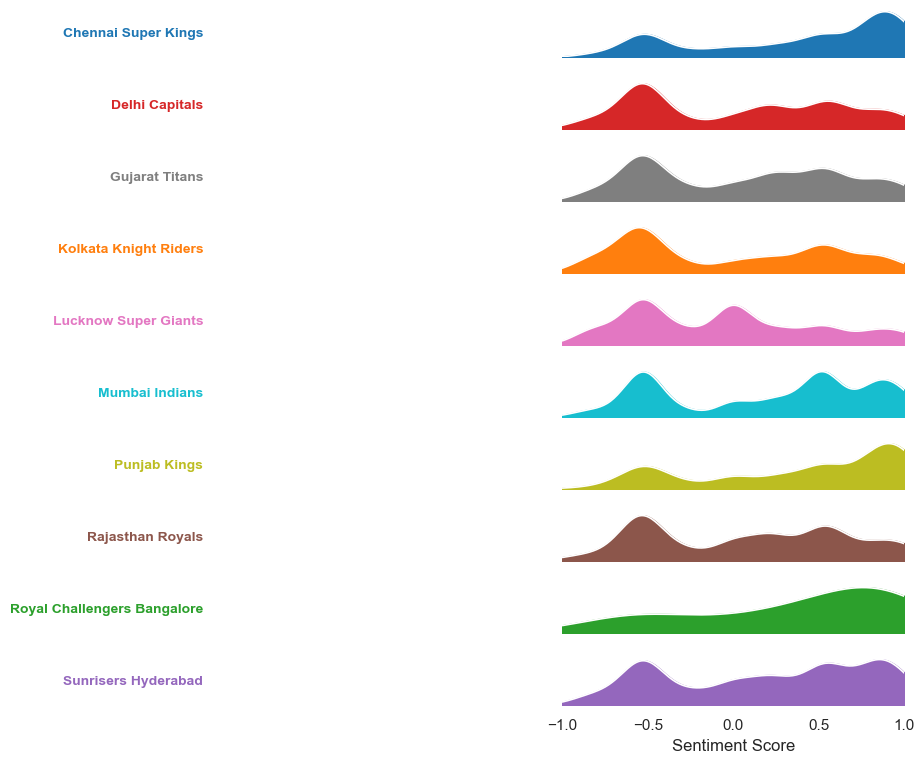

In [15]:
plot_sentiment_distributions(df_combined)

In [17]:
df_combined.to_csv("IPL Teams Reddit Comments.csv",index=False)